<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Линейная-регрессия" data-toc-modified-id="Линейная-регрессия-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Линейная регрессия</a></span><ul class="toc-item"><li><span><a href="#Визуальный-анализ" data-toc-modified-id="Визуальный-анализ-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Визуальный анализ</a></span></li><li><span><a href="#Регрессия" data-toc-modified-id="Регрессия-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Регрессия</a></span></li></ul></li></ul></div>

# Линейная регрессия

В файле auto.csv находятся данные, которые описывают характеристики 392 автомобилей. 

А именно, в данных вы найдете следующие столбцы:
1. mpg — расход топлива (миль/галлон);
2. cylinders — количество цилиндров мотора;
3. displacement — объем мотора (куб. дюйм);
4. horsepower — мощность мотора (в лошадиных силах);
5. weight — вес (тысяч фунтов);
6. acceleration — время, за которое автомобиль разгоняется до 60 mph; 
7. year — год автомобиля (по модулю 100);
8. origin — место производства (1 — Америка, 2 — Европа, 3 — Япония); 
9. name — название автомобиля.

Задания
- Визуально проанализируйте взаимосвязь между расходом топлива и остальными переменными
    - базовый код написан 
    - нужно проанализировать графики и прокомментировать наблюдения - обратите внимание на вопросы
    - по усмотрению можно сделать дополнительный анализ 
- Подготовьте данные для построения линейной регрессии
---
- Постройте линейную регрессионную модель для предсказания расхода топлива по этим данным
- Интерпретируйте значения коэффициентов регрессии (влияние каждого признака на отклик). 
    Какие признаки влияют на расход топлива и как?


## Визуальный анализ

In [38]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (10, 5)


In [39]:
import statsmodels.api as sm # все, для работы с рядами
import statsmodels.formula.api as smf

from scipy.special import inv_boxcox # обратное преобразование Бокса-Кокса 
from itertools import product # произведения множеств
import warnings # чтобы отключить предупреждения в Python

In [40]:
df = pd.read_csv('./data/auto.csv')
df.head()

,mpg,cylinders,displacement,horsepower,weight,acceleration,year,origin,name
0,18.0,8,307.0,130,3504,12.0,70,1,chevrolet chevelle malibu
1,15.0,8,350.0,165,3693,11.5,70,1,buick skylark 320
2,18.0,8,318.0,150,3436,11.0,70,1,plymouth satellite
3,16.0,8,304.0,150,3433,12.0,70,1,amc rebel sst
4,17.0,8,302.0,140,3449,10.5,70,1,ford torino


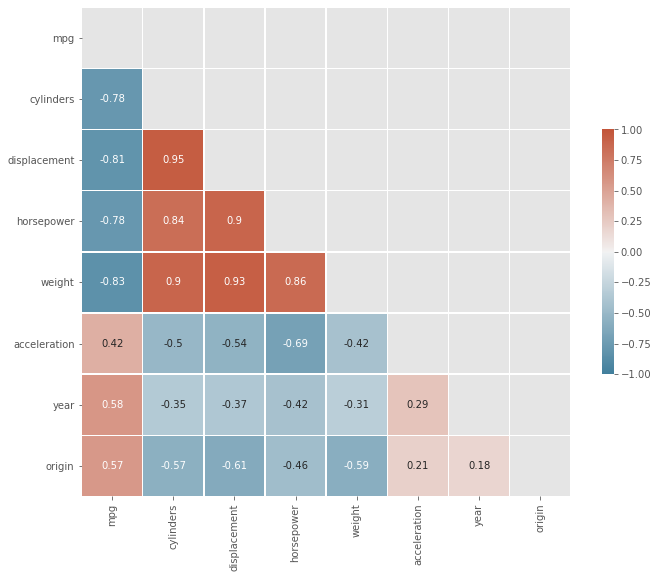

In [6]:
# https://seaborn.pydata.org/examples/many_pairwise_correlations.html
corr = df.corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, 
            square=True, linewidths=.5, cbar_kws={"shrink": .5}, 
            annot=True, 
            center=0, vmin=-1, vmax=1,
           )
plt.show()

- Стоит ли использовать все признаки?

На графике видна сильная корреляция между признаками c weight, cylinders, displacement, horsepower. Стоит попробовать удалить эти признаки weight, cylinders, displacement и посмотреть на модель. 

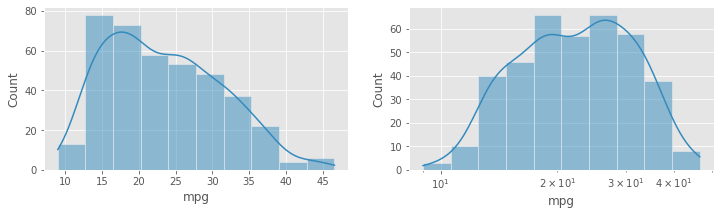

In [6]:
plt.figure(figsize=(12,3))
plt.subplot(121)
sns.histplot(df['mpg'], bins=10, kde=True)
plt.subplot(122)
sns.histplot(df['mpg'], bins=10, log_scale=True, kde=True);


- Нужно ли логарифмирование?

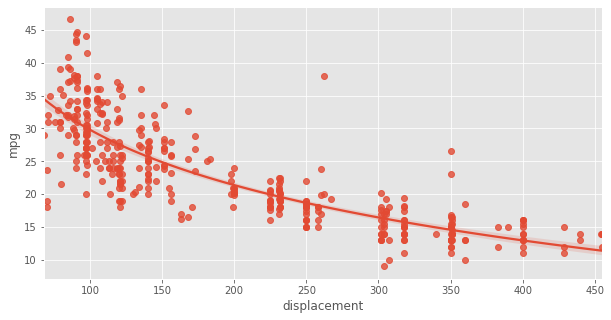

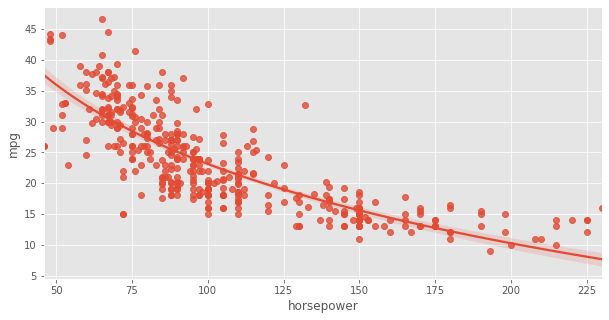

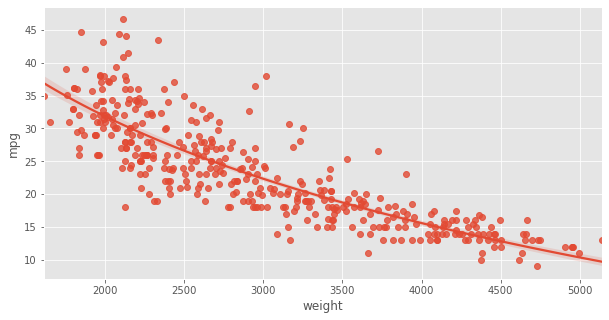

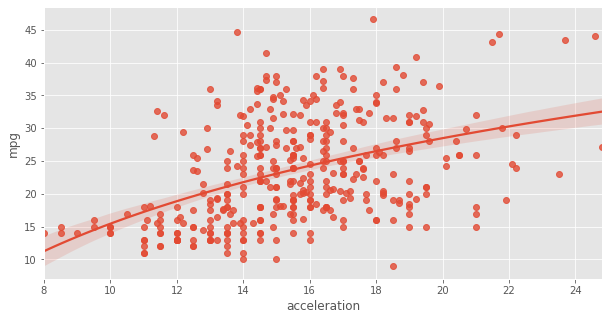

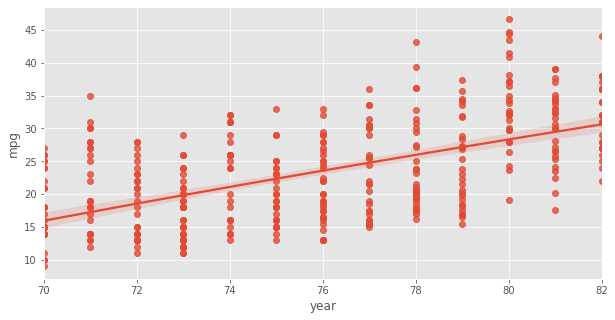

In [11]:
for x in ['displacement','horsepower','weight','acceleration','year']:
    sns.regplot(data=df, x=x, y='mpg',  
                logx=True
               )
    plt.show()

- Стоит ли попробовать логарифмировать некоторые признаки?

Да, стоит попробовать для horsepower, weight, acceleration, тк наблюдается гетероскедастичность. Я бы не стала логарифмировать year, а попробовала бы one-hot кодирование

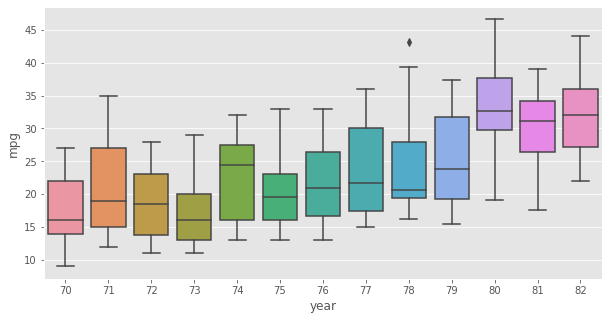

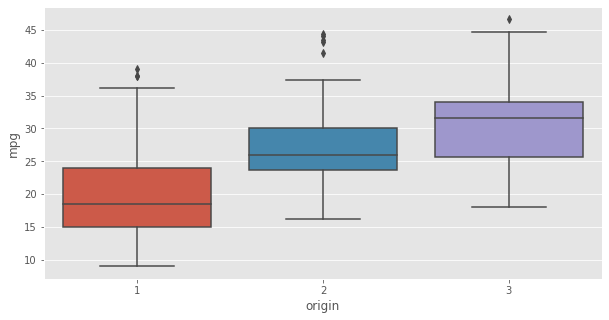

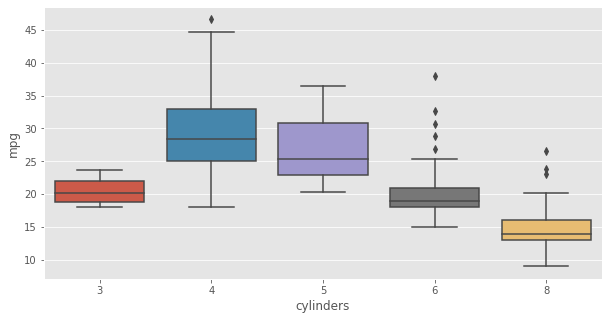

In [8]:
for x in ['year','origin','cylinders']:
    sns.boxplot(data=df, x=x, y='mpg');
    plt.show()

- Все ли признаки действительно числовые?

Нет, 'year','origin','cylinders' являются категориальными. Как правило, с такими значениями невозможно производить арифметические операции или же результаты их применения не имеют смысла. Имеет смысл использовать кодирование

## Регрессия

In [41]:
# Обработка признаков

mat = df.corr()

correlated_features = set()
for i in range(len(mat.columns)):
    for j in range(i):
        if abs(mat.iloc[i, j]) > 0.8:
            colname = mat.columns[i]
            correlated_features.add(colname)

df.drop(labels=correlated_features, axis=1, inplace=True)
df

,mpg,cylinders,acceleration,year,origin,name
0,18.0,8,12.0,70,1,chevrolet chevelle malibu
1,15.0,8,11.5,70,1,buick skylark 320
2,18.0,8,11.0,70,1,plymouth satellite
3,16.0,8,12.0,70,1,amc rebel sst
4,17.0,8,10.5,70,1,ford torino
...,...,...,...,...,...,...
387,27.0,4,15.6,82,1,ford mustang gl
388,44.0,4,24.6,82,2,vw pickup
389,32.0,4,11.6,82,1,dodge rampage
390,28.0,4,18.6,82,1,ford ranger


In [42]:
correlated_features

{'displacement', 'horsepower', 'weight'}

In [43]:
df['ln_acceleration'] = df['acceleration'].apply(np.log)

In [44]:
df.head(2)

,mpg,cylinders,acceleration,year,origin,name,ln_acceleration
0,18.0,8,12.0,70,1,chevrolet chevelle malibu,2.484907
1,15.0,8,11.5,70,1,buick skylark 320,2.442347


In [46]:
y = df[['mpg']]
X = df.drop(['mpg', 'name', 'acceleration'], axis=1)

X = sm.add_constant(X)
model = sm.OLS(y,X)
res = model.fit()
res.params

const             -21.731962
cylinders          -2.534970
year                0.761444
origin              1.821788
ln_acceleration    -0.614932
dtype: float64

In [47]:
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                    mpg   R-squared:                       0.740
Model:                            OLS   Adj. R-squared:                  0.737
Method:                 Least Squares   F-statistic:                     274.7
Date:                Wed, 06 Jul 2022   Prob (F-statistic):          1.31e-111
Time:                        16:26:46   Log-Likelihood:                -1097.5
No. Observations:                 392   AIC:                             2205.
Df Residuals:                     387   BIC:                             2225.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const             -21.7320      5.935     

Коэф-т детерминации 0,74, что близко к 1, но не достаточно, чтобы говорить о том, что переменные уравнения имеют сильную способность объяснять y. Возможно, стоит дополнительно закодировать признаки, чтобы получить более 0,8.

- Расход топлива авто растет с годами
это может быть связано с усовершенствованием атомобиилей за десятилетие:
- при увеличении acceleration (время,  за которое автомобиль разгоняется до 60 mph) снижается расход
- при увеличении количества цилиндров снижается расход